# Initial Time Series Work

The data that we're exploring is taken over multiple years. We want to see if it's possible to predict one year based on prior years' data. 
We've seen through the EDA that the scores do fluctuate drastically sometimes, but on a whole most countries follow a general trend that's consistent year to year. Hopefully our models will be able to pick up some common trends over the years.

## Setup

In [1]:
import pandas as pd
from dataset import *
from matplotlib import pyplot as plt
from sklearn.svm import SVR


## Import the data

We're working with the yearly data set so that we can split our data into multiple years to work with.

In [2]:
df = get_consistent_yearly()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Country or region             1230 non-null   object
 1   Overall rank                  1230 non-null   int64 
 2   Score                         1230 non-null   object
 3   GDP per capita                1230 non-null   object
 4   Social support                1230 non-null   object
 5   Healthy life expectancy       1230 non-null   object
 6   Freedom to make life choices  1230 non-null   object
 7   Perceptions of corruption     1229 non-null   object
 8   Generosity                    1230 non-null   object
 9   year                          1230 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 96.2+ KB
None


Country or region  Overall rank  Score GDP per capita Social support  \
0       Switzerland             1  7.587        1.39651        1.34951   
1           Iceland             2  7.561        1.30232        1.40223   
2           Denmark             3  7.527        1.32548        1.36058   
3            Norway             4  7.522          1.459        1.33095   
4            Canada             5  7.427        1.32629        1.32261   

  Healthy life expectancy Freedom to make life choices  \
0                 0.94143                      0.66557   
1                 0.94784                      0.62877   
2                 0.87464                      0.64938   
3                 0.88521                      0.66973   
4                 0.90563                      0.63297   

  Perceptions of corruption Generosity  year  
0                   0.41978    0.29678  2015  
1                   0.14145     0.4363  2015  
2                   0.48357    0.34139  2015  
3                   0.36503    0.34699  2015  
4                   0.32957    0.45811  2015

The data hasn't changed, we still have roughly 1230 countries. However, we still need to clean the comma issue in numerical data and then cast the features to the correct data type.

In [3]:
cat = ["Country or region", "Overall rank", "year"]
num = list(set(df.columns)-set(cat))
for col in num:
    df[col] = df[col].astype(str).str.replace(',','.')
df[cat] = df[cat].astype("category")
df[num] = df[num].astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Country or region             1230 non-null   category
 1   Overall rank                  1230 non-null   category
 2   Score                         1230 non-null   float64 
 3   GDP per capita                1230 non-null   float64 
 4   Social support                1230 non-null   float64 
 5   Healthy life expectancy       1230 non-null   float64 
 6   Freedom to make life choices  1230 non-null   float64 
 7   Perceptions of corruption     1229 non-null   float64 
 8   Generosity                    1230 non-null   float64 
 9   year                          1230 non-null   category
dtypes: category(3), float64(7)
memory usage: 84.7 KB


Lastly, we have one null value. This is likely an outlier in data collection, so we can safely remove it.

In [4]:
df = df.dropna()

## Regression exploration

We are trying to predict the score, so let's see if we can use an SVR to predict the score based on prior time data. 
Specifically, we have data from 2015 to 2022, so if we split our dataset up into segments, we can train on prior years and predict next years.

To train the model, we need the data.

In [5]:
X = df[['GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Perceptions of corruption',
       'Generosity']]
y = df['Score']

Now we can split the data into before 2022 and the data from 2022.

In [6]:
pre_2022 = df['year'] != 2022
X_pre_2022 = X[pre_2022]
y_pre_2022 = y[pre_2022]
post_2022 = df['year'] == 2022
X_2022 = X[post_2022]
y_2022 = y[post_2022]

Using the pre-2022 data, we can fit our data! Train the model!

In [7]:
svr_regressor = SVR(kernel='rbf', gamma='auto')
svr_regressor.fit(X_pre_2022, y_pre_2022)

SVR(gamma='auto')

Using the svd_regressor that we trained, we can now predict on the 2022 data!

Text(0.5, 1.0, 'Rank vs Score')

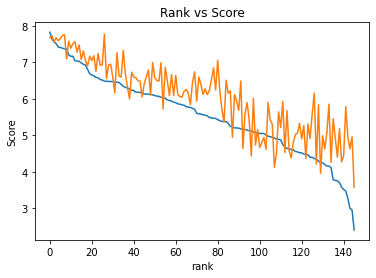

In [8]:
y_2022_pred = svr_regressor.predict(X_2022)
plt.plot(range(len(y_2022)), y_2022, label="True score")
plt.plot(range(len(y_2022_pred)), y_2022_pred, label='Predicted score')
plt.xlabel("rank")
plt.ylabel("Score")
plt.title("Rank vs Score")

The prediction is a bit fuzzy, following the general trend but not actually fitting the line. It's interest that the general descrease in score matches fairly well, but the graph looks much more eratic, and the scores are almost always overshooting.

let's try another kernel for testing.

In [9]:
svr_regressor = SVR(kernel='linear')
svr_regressor.fit(X_pre_2022, y_pre_2022)
y_2022_pred = svr_regressor.predict(X_2022)
plt.plot(range(len(y_2022)), y_2022, label="True score")
plt.plot(range(len(y_2022_pred)), y_2022_pred, label='Predicted score')
plt.xlabel("rank")
plt.ylabel("Score")
plt.title("Rank vs Score")

Text(0.5, 1.0, 'Rank vs Score')

We find About the same effectiveness in finding the 2022 score using the new kernal. Sometimes, it looks like it's matching, but there shouldn't be that much fluctuation in the data like we're seeing. Interesting.

Just to compare the general scores overall, how do the sorted scores fit? Because we're comparing scores to rank, the ranks follow from the argsort of the scores. Let's try to sort our scores and compare the graphs.

In [10]:
svr_regressor = SVR(kernel='linear')
svr_regressor.fit(X_pre_2022, y_pre_2022)
y_2022_pred = sorted(svr_regressor.predict(X_2022), reverse=True)
plt.plot(range(len(y_2022)), y_2022, label="True score")
plt.plot(range(len(y_2022_pred)), y_2022_pred, label='Predicted score')
plt.xlabel("rank")
plt.ylabel("Score")
plt.title("Rank vs Score")

Text(0.5, 1.0, 'Rank vs Score')

We definitely overshoot our estimates. Surprisingly, we fit the general trend of the data with a roughly normal distribution in scores, but we are definitely over predicting the scores for each rank.

## Conclusion

In general, the time series analysis is rough around the edges for predictability. It follows the general trend of the data, especially when reordering them into their actual ranking, although we tend to overshoot the happiness in practice.